In [1]:
from copy import deepcopy
import os
import pathlib
import sys

In [2]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import torch
import torchinfo

In [3]:
sys.path.append(os.path.join(sys.path[0], '../..'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.solver import QLSMSolver, ClassicSolver
from endure.lsm.types import Policy, System, LSMDesign
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder

In [4]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

# Loading Model

In [5]:
path = '/data/models/ltune/qlsm_tuner_v8/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))
# config = Reader.read_config('../../endure.toml')
cf = EndureCost(config)
design_type = config['lsm']['design']
design_type

'QLSM'

In [6]:
model = LTuneModelBuilder(config).build_model()
model_name = os.path.join(path, 'best.model')
# model_name = os.path.join(path, 'checkpoints/epoch_10.checkpoint')
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
status = model.load_state_dict(model_params)
model.eval()
status

<All keys matched successfully>

In [7]:
torchinfo.summary(model, (1, len(config["ltune"]["input_features"])), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
QLSMTuner                                [1, 61]                   --
├─BatchNorm1d: 1-1                       [1, 9]                    18
├─Linear: 1-2                            [1, 128]                  1,280
├─ReLU: 1-3                              [1, 128]                  --
├─Dropout: 1-4                           [1, 128]                  --
├─Linear: 1-5                            [1, 256]                  33,024
├─ReLU: 1-6                              [1, 256]                  --
├─Sequential: 1-7                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 256]                  65,792
│    └─Linear: 2-2                       [1, 256]                  65,792
│    └─Linear: 2-3                       [1, 256]                  65,792
├─Linear: 1-8                            [1, 1]                    257
├─Linear: 1-9                            [1, 30]                 

# Util Module    

In [8]:
ltune_util = LTuneEvalUtil(config, model, design_type)

In [9]:
z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
system = ltune_util.gen._sample_system()
out = ltune_util.get_ltune_out(system, z0, z1, q, w)
design = ltune_util.convert_ltune_output(out)
out, design
# system

(tensor([[4.5259, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
        grad_fn=<CatBackward0>),
 LSMDesign(h=4.52594518661499, T=30, policy=<Policy.QFixed: 3>, Q=1, Y=1.0, Z=1.0, K=[]))

# Training Loss

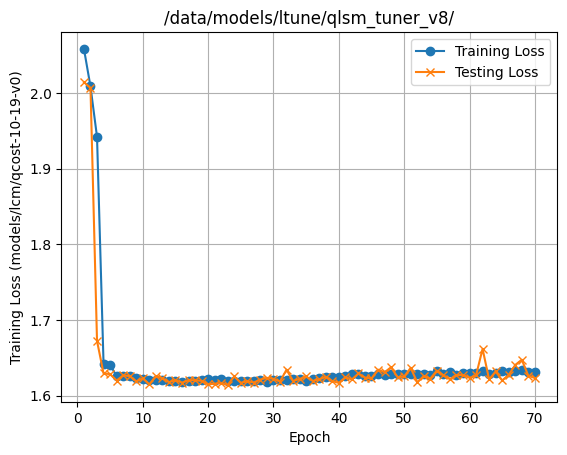

In [10]:
losses = pd.read_csv(os.path.join(path, 'losses.csv')).loc[1:70]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], '-o', label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], '-x', label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config["job"]["LTuneTrain"]["loss_fn_path"]})')
ax.set_title(f'{path}')
ax.grid()
_ = ax.legend()

In [11]:
losses.idxmin()

epoch          1
train_loss    16
test_loss     23
dtype: int64

# Evaluation

In [12]:
np.random.seed(0)
num_samples = 5000
default_sys = System()
table = []
for _ in tqdm(range(num_samples)):
    row = ltune_util.gen_sample_eval()
    table.append(row)

table = pd.DataFrame(table)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
table['delta_cost'] = (table['stune_cost'] - table['ltune_cost']) / table['stune_cost']
table['delta_loss'] = (table['stune_loss'] - table['ltune_loss']) / table['stune_loss']
table['stune_diff'] = (table['stune_cost'] - table['stune_loss']) / table['stune_cost']
table['ltune_diff'] = (table['ltune_cost'] - table['ltune_loss']) / table['ltune_cost']

In [14]:
wl_cols = ['z0', 'z1', 'q', 'w']
stune_cols = ['stune_h', 'stune_T', 'stune_Q']
ltune_cols = ['ltune_h', 'ltune_T', 'ltune_Q']
cost_cols = ['stune_cost', 'stune_loss', 'ltune_cost', 'ltune_loss', 'ltune_loss_direct']
delta_cols = ['delta_cost', 'delta_loss']
cols = wl_cols + stune_cols + ltune_cols + cost_cols + delta_cols
table[table.stune_T == 30].sort_values(by='delta_cost', ascending=True).head(20)[cols]

,z0,z1,q,w,stune_h,stune_T,stune_Q,ltune_h,ltune_T,ltune_Q,stune_cost,stune_loss,ltune_cost,ltune_loss,ltune_loss_direct,delta_cost,delta_loss
2649,0.756,0.120,0.116,0.008,6.389564,30,1,6.205133,11,1,0.555774,0.719259,0.640435,0.592079,0.592079,-0.152330,0.176820
2931,0.737,0.144,0.108,0.011,6.976572,30,1,6.126068,11,1,0.522333,0.686805,0.588403,0.543725,0.543725,-0.126490,0.208327
430,0.578,0.307,0.108,0.007,8.617837,30,1,5.398084,11,1,0.769194,0.941944,0.864284,0.836052,0.836052,-0.123623,0.112419
2419,0.695,0.087,0.210,0.008,8.417921,30,1,5.725913,13,1,1.285279,1.526399,1.409064,1.374065,1.374065,-0.096310,0.099800
333,0.197,0.567,0.216,0.020,5.478120,30,1,3.105813,13,1,1.426162,1.701253,1.535130,1.626792,1.626792,-0.076406,0.043768
722,0.176,0.653,0.167,0.004,5.351995,30,1,3.071827,11,1,2.251012,2.405519,2.416891,2.351795,2.351795,-0.073691,0.022333
3943,0.652,0.018,0.127,0.203,8.684838,30,1,5.595080,30,1,0.353476,0.383875,0.378509,0.371738,0.371738,-0.070819,0.031617
2020,0.815,0.049,0.072,0.064,9.149014,30,1,6.586909,30,1,0.249705,0.209785,0.266451,0.197695,0.197695,-0.067064,0.057627
1187,0.738,0.156,0.089,0.017,9.674371,30,1,6.270267,30,1,0.383500,0.349233,0.406456,0.348137,0.348137,-0.059858,0.003140
2773,0.808,0.037,0.153,0.002,9.540569,30,1,6.476356,30,1,0.337386,0.375080,0.357298,0.373452,0.373452,-0.059021,0.004341


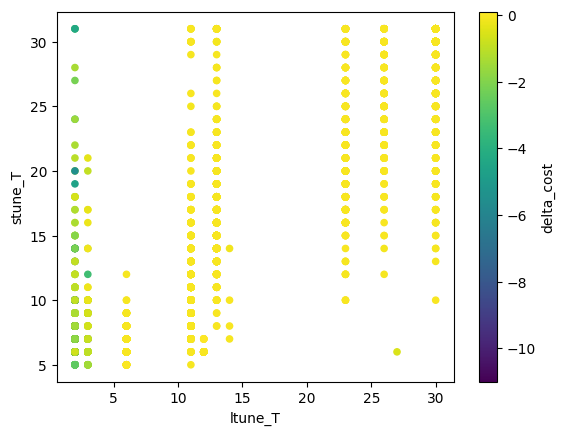

In [15]:
ax = table.plot.scatter(x='ltune_T', y='stune_T', c='delta_cost')

## Analytical Cost Model

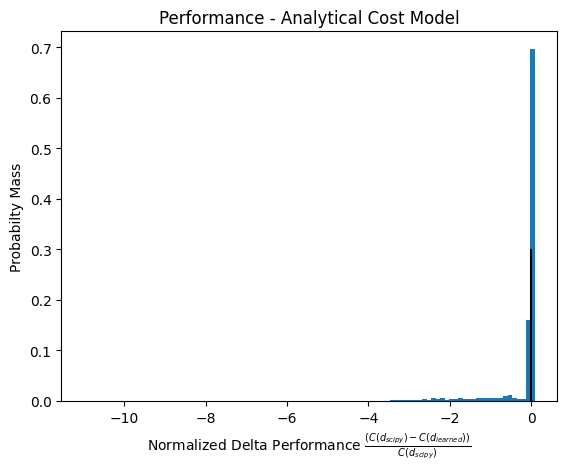

In [16]:
fig, ax = plt.subplots()
data = table['delta_cost']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), alpha=1, density=False, label='ACM', color='tab:blue')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{scipy}) - C(d_{learned}))}{C(d_{scipy})}$')
ax.set_title('Performance - Analytical Cost Model')
ax.vlines(x=0, ymin=0, ymax=0.3, color='black')
# ax.vlines(x=-0.1, ymin=0, ymax=0.3, color='black')
# ax.legend()
plt.show()

Performance values within 5% cutoff

In [17]:
cutoff = 0.05
len(table[table.delta_cost > -0.05]) / len(table)

0.8212

Positive Performance Values

In [18]:
table[table.delta_cost > 0][cols]

,z0,z1,q,w,stune_h,stune_T,stune_Q,ltune_h,ltune_T,ltune_Q,stune_cost,stune_loss,ltune_cost,ltune_loss,ltune_loss_direct,delta_cost,delta_loss
1,0.393,0.087,0.332,0.188,4.132469,10,1,4.155632,11,1,1.802391,1.865901,1.800347,1.882572,1.882572,0.001134,-0.008935
121,0.088,0.176,0.084,0.652,4.055280,6,1,4.526608,12,2,1.432787,1.409864,1.408267,1.398405,1.398405,0.017113,0.008128
204,0.101,0.067,0.150,0.682,3.236874,6,1,3.020539,6,1,1.397249,1.305236,1.396735,1.298663,1.298663,0.000368,0.005036
260,0.477,0.090,0.275,0.158,4.652286,25,1,4.525494,26,1,1.203503,1.138542,1.203483,1.133557,1.133557,0.000017,0.004378
326,0.223,0.339,0.122,0.316,5.399869,6,1,4.527061,6,1,2.000086,1.891199,1.999301,1.885755,1.885755,0.000392,0.002879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4894,0.066,0.086,0.146,0.702,3.655847,7,1,3.816150,12,2,2.978297,2.953620,2.754485,2.595850,2.595850,0.075148,0.121130
4935,0.261,0.011,0.283,0.445,2.824444,6,1,2.766872,6,1,4.789086,4.805978,4.787760,4.800061,4.800061,0.000277,0.001231
4965,0.016,0.362,0.250,0.372,2.899884,6,1,2.842576,6,1,4.195619,4.032833,4.194803,4.026376,4.026376,0.000194,0.001601
4982,0.094,0.180,0.328,0.398,0.954446,6,1,0.372901,6,1,6.806421,6.571061,6.804369,6.531369,6.531369,0.000302,0.006040


## Learned Cost Model

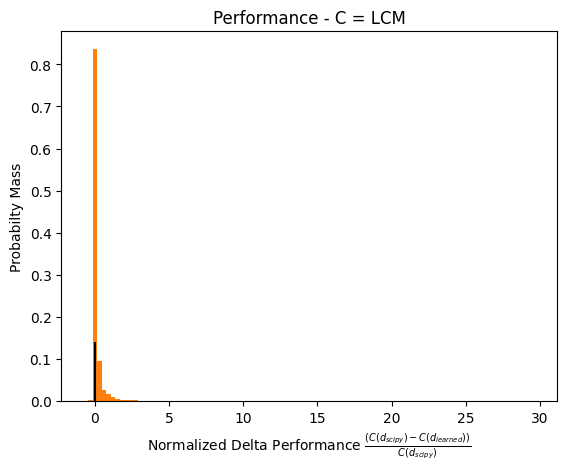

In [19]:
fig, ax = plt.subplots()
data = table['delta_loss']
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data), density=False, color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Normalized Delta Performance $\\frac{(C(d_{scipy}) - C(d_{learned}))}{C(d_{scipy})}$')
ax.set_title('Performance - C = LCM')
ax.vlines(x=0, ymin=0, ymax=0.14, color='black')
plt.show()

## Difference in ACM and LCM

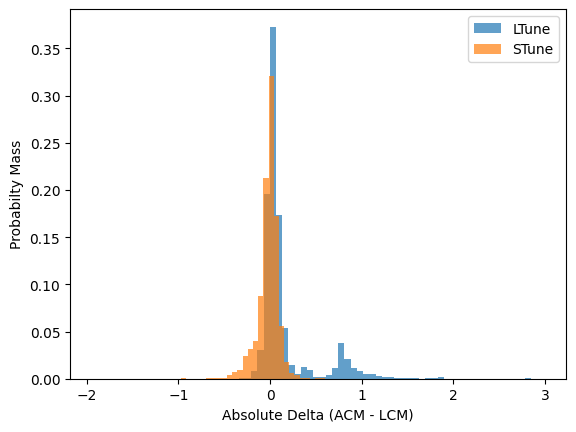

In [20]:
fig, ax = plt.subplots()
ldata = table['ltune_diff']
sdata = table['stune_diff']
ax.hist(ldata, weights=np.ones_like(ldata)/len(ldata), bins=50, alpha=0.7, label='LTune', color='tab:blue')
ax.hist(sdata, weights=np.ones_like(sdata)/len(sdata), bins=50, alpha=0.7, label='STune', color='tab:orange')
ax.set_ylabel('Probabilty Mass')
ax.set_xlabel('Absolute Delta (ACM - LCM)')
ax.legend()
plt.show()

In [21]:
table['ltune_mbuff'] = ((table['H'] - table['ltune_h']) * table['N']) / (1 * 1024 * 1024 * 1024 * 8)

## Workload Correlations

In [22]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure(figsize=(5,5))
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0.5]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads', labelpad=6)
    ax.set_ylabel('Range-Reads', labelpad=6)
    ax.set_zlabel('Writes', labelpad=6)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc, pad=0.11, shrink=0.6)
    cbar.set_label(trend)
    cbar.ax.tick_params(labelsize=12)
    font = {'size': 12}
    ax.tick_params('x', labelsize=font['size'])
    ax.tick_params('y', labelsize=font['size'])
    ax.tick_params('z', labelsize=font['size'])
    
    return fig, ax, sc, cbar

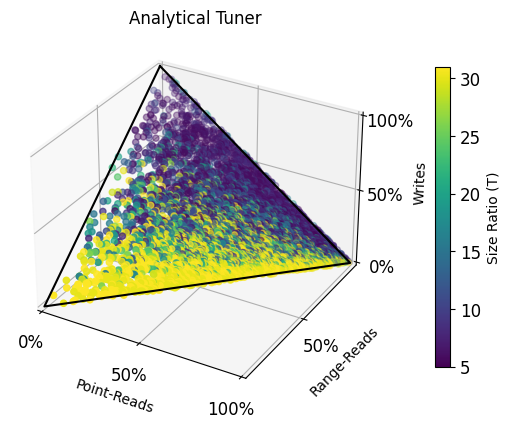

In [23]:
# plt.rcParams.update({'font.size': 18})
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_T')
cbar.set_label('Size Ratio (T)')
ax.set_title('Analytical Tuner')
plt.show()
save_fig(fig, 'analytical_tuner_size_ratio.pdf')

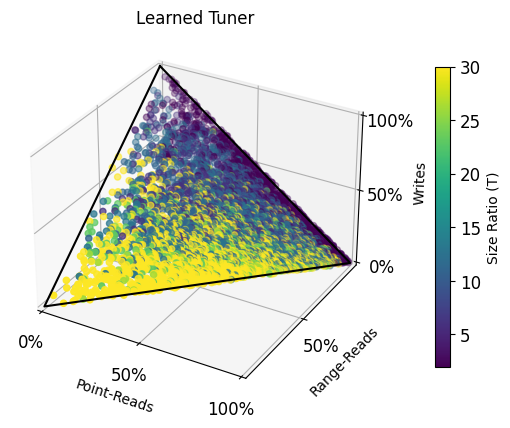

In [24]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_T')
ax.set_title('Learned Tuner')
cbar.set_label('Size Ratio (T)')
plt.show()
save_fig(fig, 'learned_tuner_size_ratio.pdf')

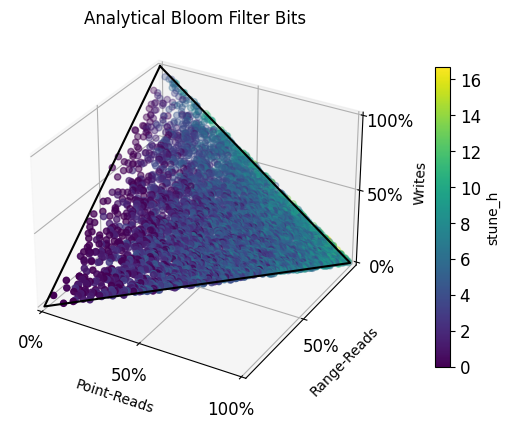

In [25]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_h')
ax.set_title('Analytical Bloom Filter Bits')
plt.show()

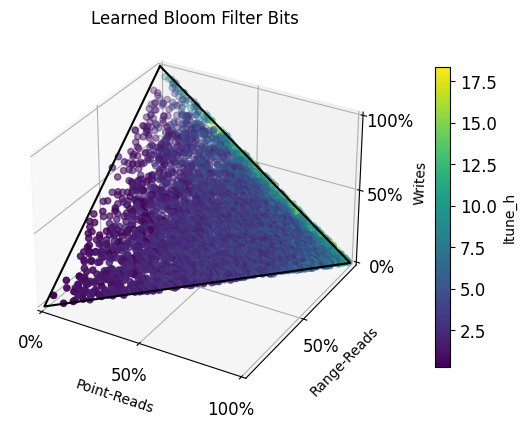

In [26]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_h')
ax.set_title('Learned Bloom Filter Bits')
plt.show()

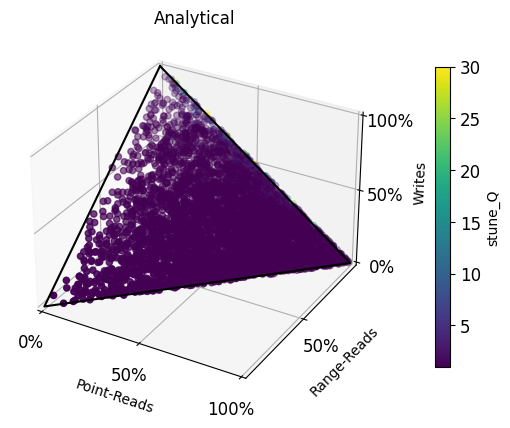

In [27]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='stune_Q')
ax.set_title('Analytical')
plt.show()

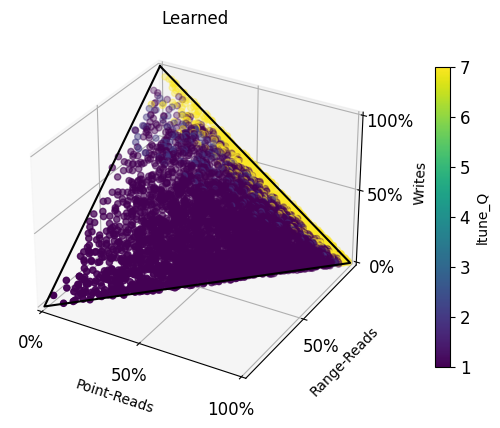

In [28]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='ltune_Q')
ax.set_title('Learned')
plt.show()

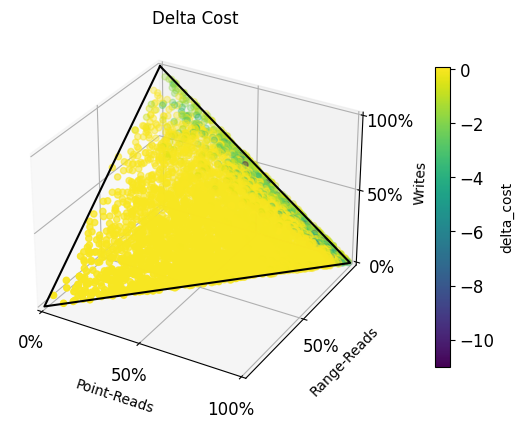

In [29]:
fig, ax, sc, cbar = plot_workload_trend(table, trend='delta_cost')
ax.set_title('Delta Cost')
plt.show()

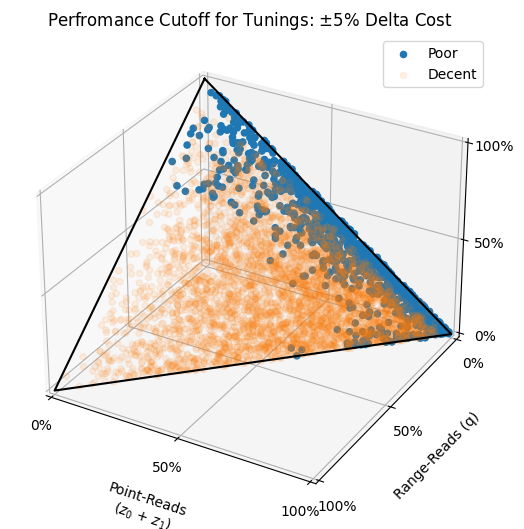

In [30]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
ax.set_ylabel('Range-Reads (q)', labelpad=10)
ax.set_zlabel('Writes (w)', labelpad=10)

cutoff = (0.05)
groupa = table[(table['delta_cost'] > -cutoff) & (table['delta_cost'] < cutoff)]
groupb = table[(table['delta_cost'] < -cutoff) | (table['delta_cost'] > cutoff)]
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label='Poor', alpha=1)
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label='Decent', alpha=0.1)
ax.set_title(f'Perfromance Cutoff for Tunings: $\pm${cutoff:.0%} Delta Cost')
ax.legend()
plt.show()

In [31]:
table

,z0,z1,q,w,B,s,E,H,N,stune_policy,...,ltune_T,ltune_Q,ltune_cost,ltune_loss,ltune_loss_direct,delta_cost,delta_loss,stune_diff,ltune_diff,ltune_mbuff
0,0.424,0.014,0.208,0.354,64.0,1.641769e-08,1024,17.869184,517693031,3,...,13,1,0.585912,0.552780,0.552780,-0.076572,0.046410,-0.065127,0.056547,0.816006
1,0.393,0.087,0.332,0.188,8.0,4.597387e-09,4096,10.751623,279207654,3,...,11,1,1.800347,1.882572,1.882572,0.001134,-0.008935,-0.035237,-0.045672,0.214396
2,0.778,0.055,0.037,0.130,32.0,6.659778e-08,2048,14.722578,607843536,3,...,11,1,0.326578,0.280811,0.280811,-0.040047,0.108104,-0.002689,0.140141,0.527863
3,0.118,0.025,0.497,0.360,8.0,2.070984e-08,4096,12.807162,868281747,3,...,11,1,3.663229,3.760247,3.760247,-0.004130,-0.015403,-0.015088,-0.026484,1.159283
4,0.186,0.031,0.520,0.263,4.0,4.833702e-08,8192,11.219929,162515875,3,...,6,1,4.654525,4.699321,4.699321,-0.014014,-0.006885,-0.016772,-0.009624,0.186938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.384,0.431,0.090,0.095,4.0,3.346289e-08,8192,9.988714,238024067,3,...,6,1,1.638977,1.501301,1.501301,0.000055,0.002382,0.081865,0.084001,0.129513
4996,0.493,0.227,0.054,0.226,32.0,1.643258e-08,2048,7.949271,724029682,3,...,11,1,0.669769,0.557447,0.557447,-0.013687,0.011421,0.146564,0.167703,0.237750
4997,0.204,0.086,0.518,0.192,64.0,9.927115e-08,2048,11.720760,287079092,3,...,30,1,1.352216,1.367809,1.367809,-0.002788,0.005529,-0.019991,-0.011531,0.299545
4998,0.069,0.044,0.855,0.032,32.0,7.939371e-08,2048,9.523554,393768038,3,...,30,1,2.361020,2.268932,2.268932,-0.007283,0.189475,-0.194281,0.039004,0.372091
